In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers.experimental import preprocessing

# Model Architecture
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

# System libraries
from pathlib import Path
import os.path

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model Hypertunning
from kerastuner.tuners import RandomSearch
import keras_tuner as kt

Using TensorFlow backend


C:\Users\SIMRAN\AppData\Local\Temp\ipykernel_3980\2792438293.py:40: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
train_path = 'Face_Mask_Dataset\Train'
test_path = 'Face_Mask_Dataset\Test'
pred_path = 'Face_Mask_Dataset\Validation'

In [3]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

# data augmentation for testing
Validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [4]:
images_size = 200
batch_size = 32

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='binary'        # Mode for class labels (categorical for one-hot encoding)
)
Validation_generator = Validation_datagen.flow_from_directory(
    pred_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='binary'        # Mode for class labels (categorical for one-hot encoding)
)


# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [6]:
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

['WithMask', 'WithoutMask']


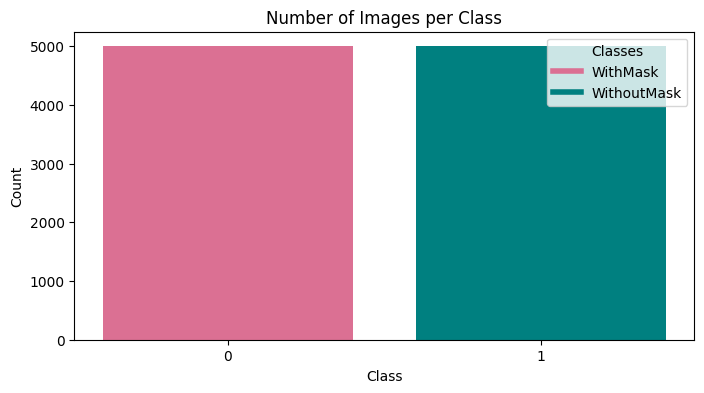

In [30]:
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {'0': 0, '1': 0}

for i in range(len(train_generator)):
    _, batch_labels = train_generator[i]
    for label in batch_labels:
        class_label = str(int(label))  # Converting label to string and then to '0' or '1'
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = ['palevioletred', 'teal']  # Choose colors as needed

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

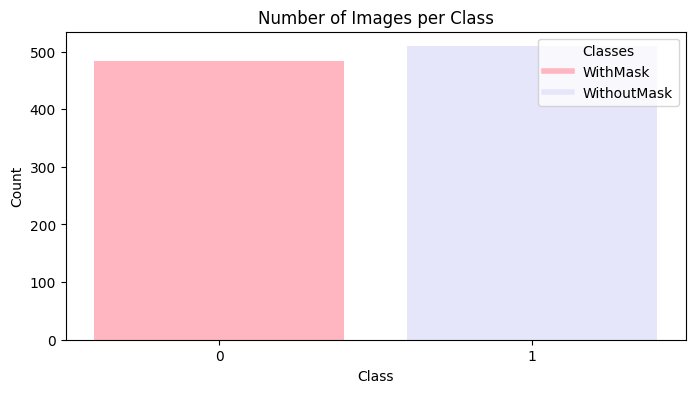

In [22]:
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {'0': 0, '1': 0}

for i in range(len(test_generator)):
    _, batch_labels = test_generator[i]
    for label in batch_labels:
        class_label = str(int(label))  # Converting label to string and then to '0' or '1'
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = ['lightpink', 'lavender']  # Choose colors as needed

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [27]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = target_gen.class_indices.keys()

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n, image in enumerate(batch_images[:36]):  # Display the first 36 images
        plt.subplot(6, 6, n + 1)
        plt.imshow(image)
        # Display class label based on class names
        class_idx = int(batch_labels[n])
        class_label = list(class_labels)[class_idx]
        plt.title(class_label)
        plt.axis('off')
    plt.show()

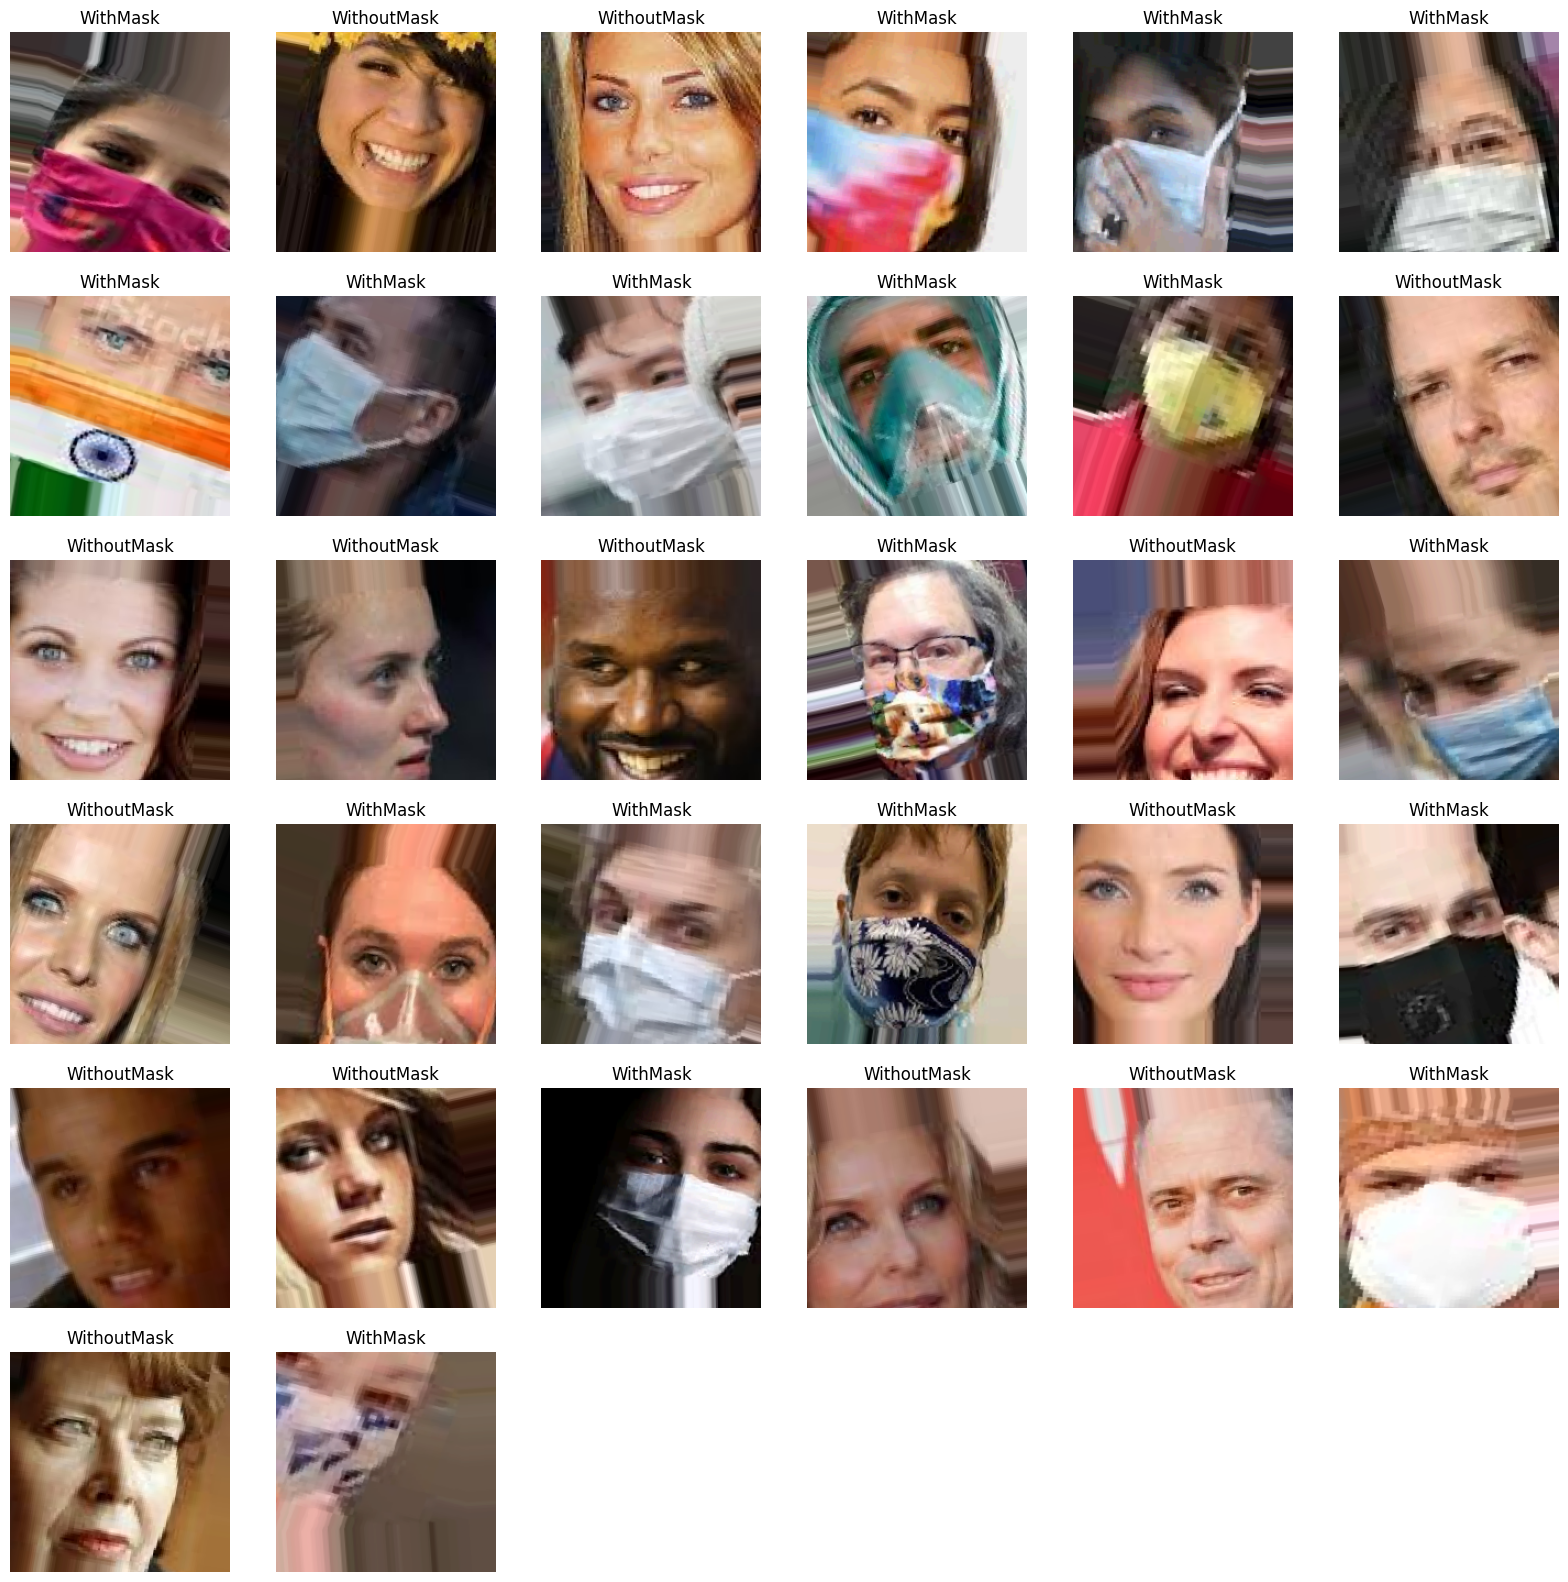

In [29]:
Show_Images(train_generator)

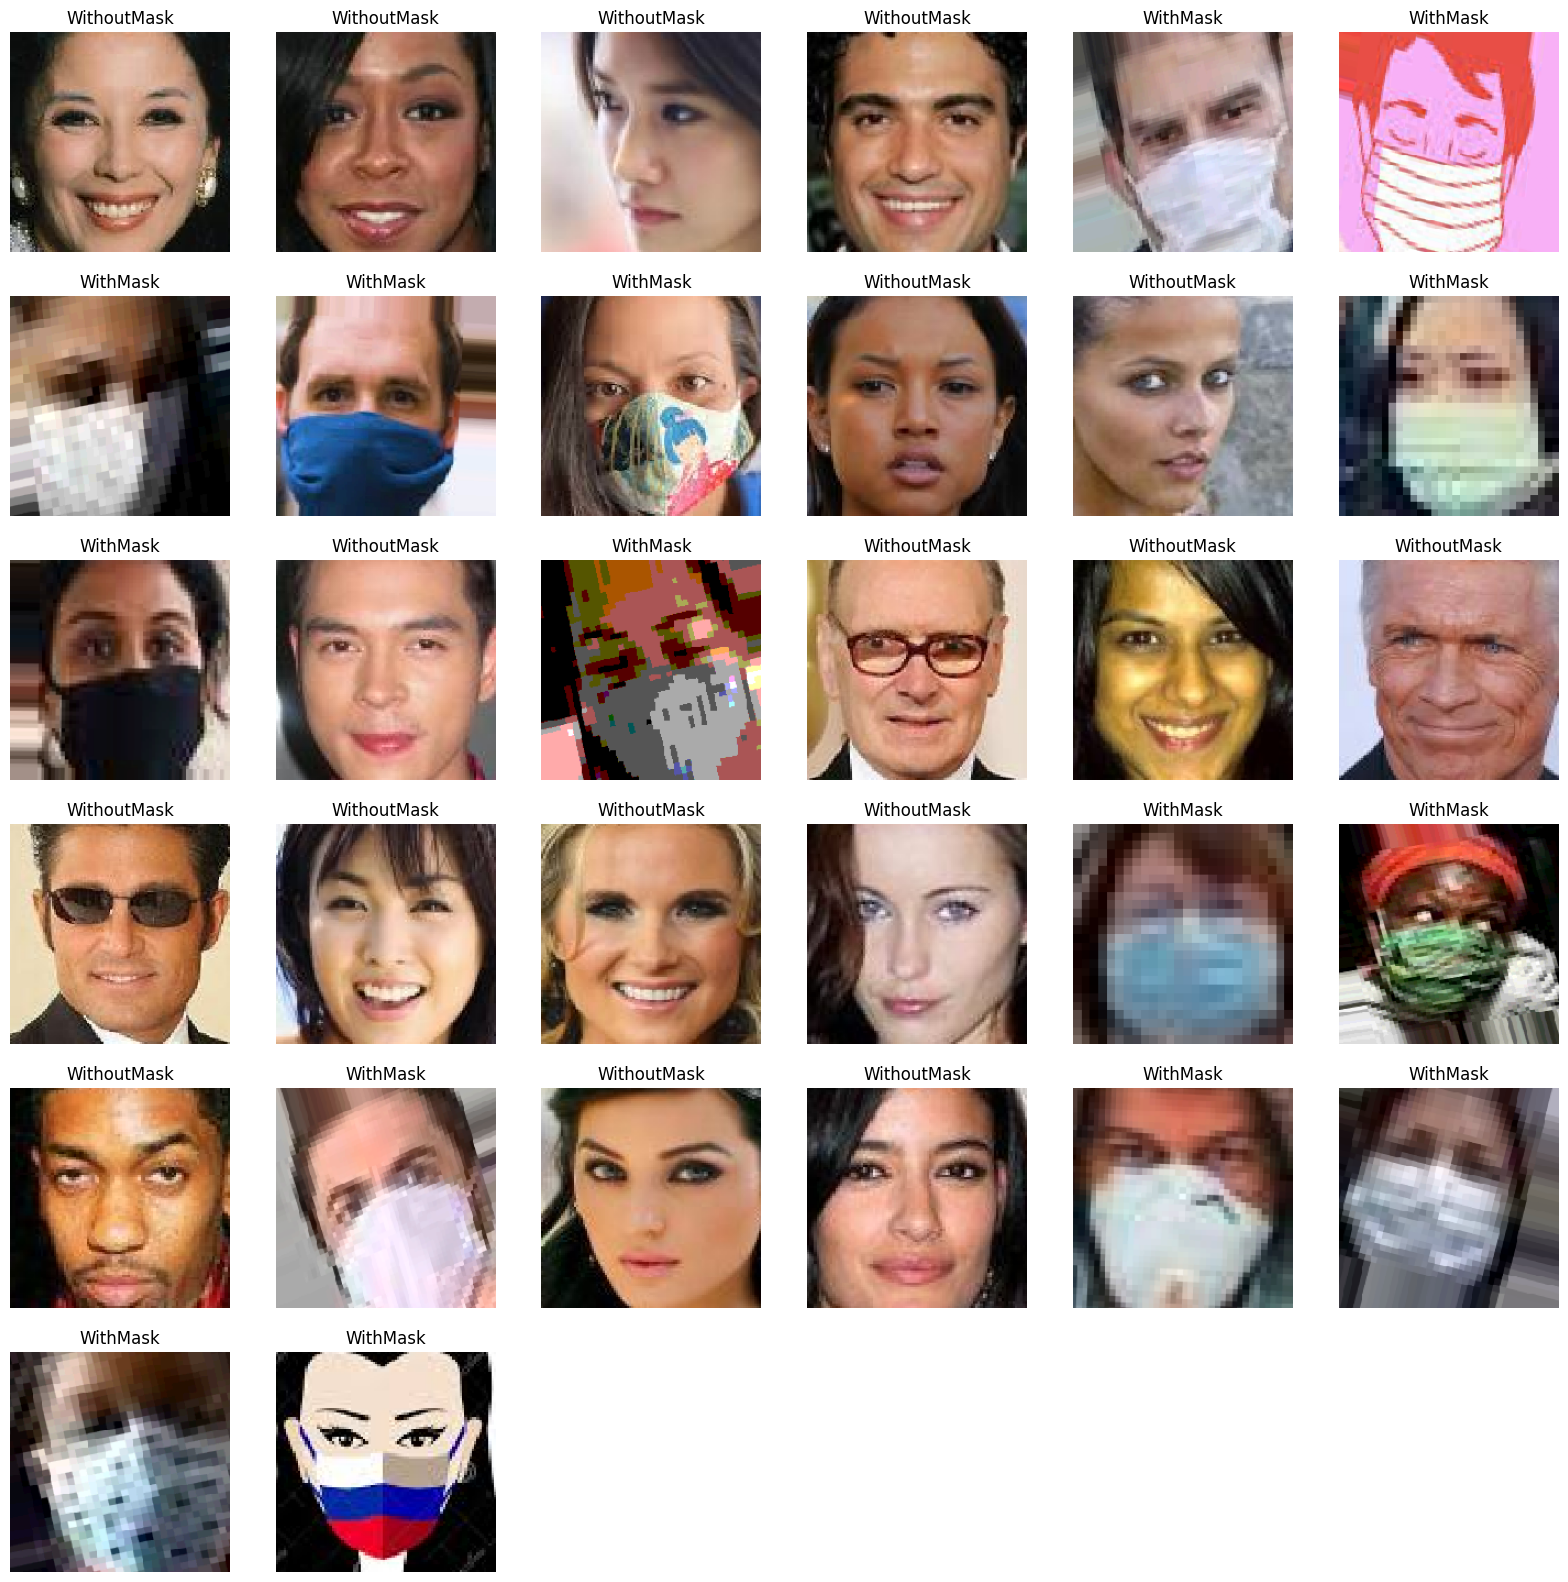

In [28]:
Show_Images(test_generator)

In [10]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [7]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric to monitor for changes (usually validation accuracy)
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.0001       # Lower bound for the learning rate (it won't go below this value)
)

In [8]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)

In [11]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

In [17]:
# Collect all TL models
TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    
]

# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

In [12]:
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [14]:
X_sub.shape

(1024, 200, 200, 3)

In [14]:
y_sub.shape

(1024,)

In [20]:
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):
    
    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss=keras.losses.BinaryFocalCrossentropy(
                gamma=2, from_logits=True),
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics=[keras.metrics.BinaryAccuracy()]
    )
    
    # Train the model on a subset of the training data.
    history = model.fit(
        X_sub, y_sub,
        epochs=7,
        validation_split=0.2,
        batch_size=batch_size
    )
        
    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/7
26/26 [==============================] - 69s 3s/step - loss: 0.7722 - binary_accuracy: 0.9426 - val_loss: 0.1061 - val_binary_accuracy: 0.9902
Epoch 2/7
26/26 [==============================] - 60s 2s/step - loss: 0.1314 - binary_accuracy: 0.9927 - val_loss: 0.4738 - val_binary_accuracy: 0.9902
Epoch 3/7
26/26 [==============================] - 70s 3s/step - loss: 0.0089 - binary_accuracy: 0.9988 - val_loss: 0.1824 - val_binary_accuracy: 0.9854
Epoch 4/7
26/26 [==============================] - 68s 3s/step - loss: 0.0141 - binary_accuracy: 0.9976 - val_loss: 0.2094 - val_binary_accuracy: 0.9902
Epoch 5/7
26/26 [==============================] - 61s 2s/step - loss: 2.1837e-27 - binary_accuracy: 1.0000 - val_loss: 0.2155 - val_binary_accuracy: 0.9902
Epoch 6/7
26/26 [==============================] - 61s 2s/step - loss: 5.8705e-18 - binary_accuracy: 1.0000 - val_loss: 0.2159 - val_binary_accuracy: 0.9902
Epoch 7/7
26/26 [==============================] - 61s 2s/step - loss: 1.7

Training Tl Models:  25%|██▌       | 1/4 [07:31<22:34, 451.54s/it]

Epoch 1/7
26/26 [==============================] - 181s 7s/step - loss: 0.2530 - binary_accuracy: 0.9744 - val_loss: 1.3401 - val_binary_accuracy: 0.9854
Epoch 2/7
26/26 [==============================] - 163s 6s/step - loss: 0.1110 - binary_accuracy: 0.9951 - val_loss: 0.2933 - val_binary_accuracy: 0.9902
Epoch 3/7
26/26 [==============================] - 163s 6s/step - loss: 0.0227 - binary_accuracy: 0.9963 - val_loss: 0.3282 - val_binary_accuracy: 0.9902
Epoch 4/7
26/26 [==============================] - 163s 6s/step - loss: 7.0341e-08 - binary_accuracy: 1.0000 - val_loss: 0.4705 - val_binary_accuracy: 0.9854
Epoch 5/7
26/26 [==============================] - 163s 6s/step - loss: 1.6563e-15 - binary_accuracy: 1.0000 - val_loss: 0.4812 - val_binary_accuracy: 0.9854
Epoch 6/7
26/26 [==============================] - 163s 6s/step - loss: 1.5518e-08 - binary_accuracy: 1.0000 - val_loss: 0.4712 - val_binary_accuracy: 0.9854
Epoch 7/7
26/26 [==============================] - 175s 7s/step 

Training Tl Models:  50%|█████     | 2/4 [27:05<29:12, 876.38s/it]

Epoch 1/7
26/26 [==============================] - 39s 1s/step - loss: 1.2112 - binary_accuracy: 0.9011 - val_loss: 0.4642 - val_binary_accuracy: 0.9902
Epoch 2/7
26/26 [==============================] - 33s 1s/step - loss: 0.1054 - binary_accuracy: 0.9902 - val_loss: 0.4010 - val_binary_accuracy: 0.9854
Epoch 3/7
26/26 [==============================] - 31s 1s/step - loss: 0.0451 - binary_accuracy: 0.9963 - val_loss: 0.1985 - val_binary_accuracy: 0.9902
Epoch 4/7
26/26 [==============================] - 32s 1s/step - loss: 8.1500e-09 - binary_accuracy: 1.0000 - val_loss: 0.1844 - val_binary_accuracy: 0.9902
Epoch 5/7
26/26 [==============================] - 34s 1s/step - loss: 8.5064e-09 - binary_accuracy: 1.0000 - val_loss: 0.1836 - val_binary_accuracy: 0.9902
Epoch 6/7
26/26 [==============================] - 35s 1s/step - loss: 1.0320e-08 - binary_accuracy: 1.0000 - val_loss: 0.1836 - val_binary_accuracy: 0.9902
Epoch 7/7
26/26 [==============================] - 34s 1s/step - loss:

Training Tl Models:  75%|███████▌  | 3/4 [31:03<09:45, 585.14s/it]

Epoch 1/7
26/26 [==============================] - 74s 3s/step - loss: 0.7418 - binary_accuracy: 0.9341 - val_loss: 0.0117 - val_binary_accuracy: 0.9951
Epoch 2/7
26/26 [==============================] - 71s 3s/step - loss: 0.0332 - binary_accuracy: 0.9939 - val_loss: 0.0233 - val_binary_accuracy: 0.9902
Epoch 3/7
26/26 [==============================] - 71s 3s/step - loss: 2.9089e-04 - binary_accuracy: 1.0000 - val_loss: 0.3214 - val_binary_accuracy: 0.9902
Epoch 4/7
26/26 [==============================] - 70s 3s/step - loss: 0.0112 - binary_accuracy: 0.9988 - val_loss: 0.0437 - val_binary_accuracy: 0.9951
Epoch 5/7
26/26 [==============================] - 71s 3s/step - loss: 0.0044 - binary_accuracy: 0.9988 - val_loss: 0.0392 - val_binary_accuracy: 0.9951
Epoch 6/7
26/26 [==============================] - 71s 3s/step - loss: 2.9167e-05 - binary_accuracy: 1.0000 - val_loss: 0.0378 - val_binary_accuracy: 0.9951
Epoch 7/7
26/26 [==============================] - 70s 3s/step - loss: 3.5

Training Tl Models: 100%|██████████| 4/4 [39:23<00:00, 590.76s/it]


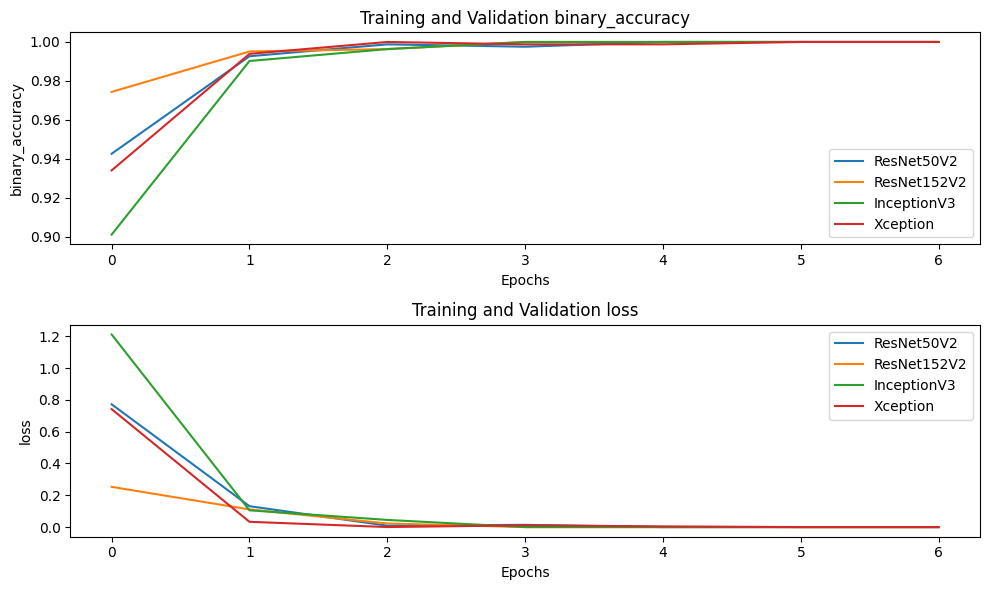

In [22]:
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['binary_accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

In [12]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))

In [13]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [14]:
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1,activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

In [15]:
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [16]:
model.compile(optimizer=optimizer,
             loss="binary_crossentropy",
              metrics=['accuracy']
             )

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=Validation_generator,
    batch_size=batch_size,
    validation_steps=Validation_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/5
312/312 [==============================] - 730s 2s/step - loss: 3.7357 - accuracy: 0.9729 - val_loss: 0.0250 - val_accuracy: 0.9962 - lr: 0.0081
Epoch 2/5
312/312 [==============================] - 713s 2s/step - loss: 0.5237 - accuracy: 0.9806 - val_loss: 0.0087 - val_accuracy: 0.9987 - lr: 0.0065
Epoch 3/5
312/312 [==============================] - 770s 2s/step - loss: 0.1959 - accuracy: 0.9838 - val_loss: 0.0079 - val_accuracy: 0.9987 - lr: 0.0052
Epoch 4/5
312/312 [==============================] - 789s 3s/step - loss: 0.0946 - accuracy: 0.9880 - val_loss: 0.0128 - val_accuracy: 0.9987 - lr: 0.0042
Epoch 5/5
312/312 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9847
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0016969311982393265.
312/312 [==============================] - 719s 2s/step - loss: 0.1140 - accuracy: 0.9847 - val_loss: 0.0238 - val_accuracy: 0.9987 - lr: 0.0034


In [18]:
pre = model.predict(test_generator)
pre

31/31 [==============================] - 57s 2s/step


array([[0.00000000e+00],
       [1.00000000e+00],
       [4.84021685e-19],
       [0.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.48106982e-12],
       [1.00000000e+00],
       [3.97644442e-08],
       [1.00000000e+00],
       [1.00000000e+00],
       [4.27222692e-26],
       [1.25318133e-37],
       [1.00000000e+00],
       [3.93609163e-14],
       [9.47519019e-03],
       [1.00000000e+00],
       [4.65734391e-21],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [2.56611453e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.61295667e-08],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [5.71558012e-35],
       [1.00000000e+00],
       [1.00000000e+00],
       [4.73000666e-11],
       [6.69253815e-04],
       [2.78472130e-21],


In [19]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01107520516961813
Test accuracy: 0.9939516186714172


In [49]:
model.save('save_m0.h5')